In [1]:
import numpy as np
import pandas as pd
import glob
import unicodedata
import string
import os
import time
from io import open
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [2]:
def unicode_to_ascii(s):
    """Unicode string to plain ASCII.
    
    """
    decoded = "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )
    return decoded


def read_lines(filename):
    """Read a file and split into lines.
    
    """
    lines = open(filename, encoding="utf-8").read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


def letter_to_index(letter):
    """Find letter index from all_letters.
    
    """
    return all_letters.find(letter)


def letter_to_tensor(letter):
    """Create 1-hot encoding of letters.
    
    """
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


def line_to_tensor(line):
    """Convert line of text into (line, 1, n_letters) tensor.
    
    Extra dimension in middle is so a lines can be passed into
    network 1-by-1 as a 2D vector of size (1, n_letters). 
    
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def cat_from_output(output):
    """Get category by finding argmax of output.
    
    """
    _, max_i = output.max(1)
    category_i = max_i.item()
    return all_categories[category_i], category_i


def random_ex(train=True):
    """Select a random training example and return category/line contents.
    
    """
    category = np.random.choice(all_categories)
    # 0 = train, 1 = val
    if train:
        line_ps = (1 - category_lines_tv_split[category]) / (1 - category_lines_tv_split[category]).sum()
    else:
        line_ps = category_lines_tv_split[category] / category_lines_tv_split[category].sum()
    
    line = np.random.choice(category_lines[category], p=line_ps)
    category_tensor = torch.tensor(
        [all_categories.index(category)],
        dtype=torch.long
    )
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.h1_fc = nn.Linear(input_size + hidden_size, hidden_size)
        self.y_fc = nn.Linear(hidden_size, output_size)
        
        self.tanh = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h0):
        xh0 = torch.cat((x, h0), 1)
        
        h1 = self.h1_fc(xh0)
        h1 = self.tanh(h1)
        
        y = self.y_fc(h1)
        y = self.log_softmax(y)
        
        return y, h1
    
    def zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
name_files = glob.glob("../data/rnn_char_class_data/names/*.txt")
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
# category_lines dict. -- a list of names per language
category_lines = {}
all_categories = []

for filename in name_files:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
print(
    np.mean([len(v) for k, v in category_lines.items()])
)

print(
    np.sum([len(v) for k, v in category_lines.items()])
)

print(category_lines["Italian"][:5])

1115.2222222222222
20074
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [7]:
category_lines_tv_split = {k: np.random.choice((0, 1), p=(0.8, 0.2), size=len(v)) for k, v in category_lines.items()}

In [8]:
print(letter_to_tensor("J"))
print(line_to_tensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [9]:
def time_since(since):
    elapsed = time.time() - since
    m = elapsed // 60
    s = elapsed % 60
    return f"{m}m {s}s"


def train_line(model, crit, opt, category_tensor, line_tensor):
    """Execute forward passes for one line.
    
    """
    opt.zero_grad()
    # Empty initial hidden state
    h = model.zero_hidden().to(device)
    for c in line_tensor:
        yhat, h = model(c, h)
        
    loss = crit(yhat, category_tensor)
    loss.backward()
    
    opt.step()
    
    return yhat, loss.item()


def train():
    running_loss = 0.0
    losses = np.zeros(n_epochs // plot_every)
    
    model.train()
    # model.zero_grad()
    
    start = time.time()
    for i in range(1, n_epochs + 1):
        for b in range(batch_size):
            category, line, category_tensor, line_tensor = random_ex(train=True)
            category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)
            
            yhat, loss = train_line(model, criterion, optimizer, category_tensor, line_tensor)
            running_loss += loss
        
        if i % print_every == 0:
            print(f"{i} {i / n_epochs * 100}% ({time_since(start)}): {loss}")
        
        if i % plot_every == 0:
            # losses.append(running_loss / plot_every)
            losses[i // plot_every - 1] = running_loss / plot_every
            running_loss = 0.0
    
    return losses


In [10]:
n_hidden = 128
model = RNN(n_letters, n_hidden, n_categories)

In [11]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# Full line tensor
with torch.no_grad():
    x = line_to_tensor("Albert")
    h0 = model.zero_hidden()
    y, h1 = model(x[0], h0)
print(y)
print(cat_from_output(y))
for i in range(10):
    category, line, category_tensor, line_tensor = random_ex(train=True)
    print(f"Category: {category} / Line: {line}")

tensor([[-2.8172, -2.9477, -2.9613, -2.7771, -2.9344, -2.7862, -2.8618, -2.8612,
         -2.9798, -2.8245, -2.8764, -2.8486, -2.8403, -2.9949, -2.8376, -2.9458,
         -3.0094, -2.9699]])
('French', 3)
Category: Dutch / Line: Horn
Category: Korean / Line: Chang
Category: Dutch / Line: Aggelen
Category: Spanish / Line: Costa
Category: Arabic / Line: Najjar
Category: Korean / Line: Shim
Category: Italian / Line: Uccello
Category: Irish / Line: O'Hagan
Category: Russian / Line: Gaspirovich
Category: Vietnamese / Line: Cao


In [13]:
batch_size = 32
n_epochs = 5000
print_every = 100
plot_every = print_every // 2
fancy_check = "\u2713"
fancy_x = "\u2717"
## Train on 1 line at a time, so GPU is slower
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [14]:
model.to(device)
losses = train()

100 2.0% (0.0m 6.743552923202515s): 3.8934555053710938
200 4.0% (0.0m 13.243626356124878s): 1.2102251052856445
300 6.0% (0.0m 19.704188108444214s): 1.1828172206878662
400 8.0% (0.0m 26.039878368377686s): 0.4375629425048828
500 10.0% (0.0m 32.48785758018494s): 2.9416873455047607
600 12.0% (0.0m 38.880271196365356s): 0.3889067471027374
700 14.000000000000002% (0.0m 45.28133201599121s): 0.3945557773113251
800 16.0% (0.0m 52.12377619743347s): 0.877832293510437
900 18.0% (0.0m 58.881447315216064s): 1.8206795454025269
1000 20.0% (1.0m 5.835557460784912s): 3.844770669937134
1100 22.0% (1.0m 12.56998896598816s): 2.058441162109375
1200 24.0% (1.0m 19.47483205795288s): 0.05272490158677101
1300 26.0% (1.0m 26.1983482837677s): 0.07536372542381287
1400 28.000000000000004% (1.0m 32.55039358139038s): 0.5509989857673645
1500 30.0% (1.0m 38.93166947364807s): 2.951063632965088
1600 32.0% (1.0m 45.23301315307617s): 0.6383062601089478
1700 34.0% (1.0m 51.80900859832764s): 1.5359270572662354
1800 36.0% (1.

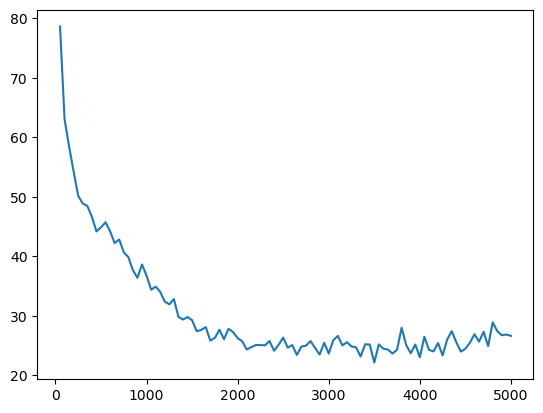

In [15]:
sns.lineplot(x=np.arange(plot_every, n_epochs + 1, plot_every), y=losses)
plt.show()

In [16]:
def evaluate_line(model, line_tensor):
    h = model.zero_hidden().to(device)
    for c in line_tensor:
        yhat, h = model(c, h)
    
    return yhat


def evaluate_confusion(model, n_val_samps, train):
    confusion_m = np.zeros((n_categories, n_categories))
    model.eval()
    with torch.no_grad():
        for i in range(n_val_samps):
            category, line, category_tensor, line_tensor = random_ex(train=train)
            category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)

            yhat = evaluate_line(model, line_tensor)
            yhat_cat, yhat_cat_i = cat_from_output(yhat)
            cat_i = all_categories.index(category)
            confusion_m[cat_i][yhat_cat_i] += 1
    # Normalize each row entry by sum of its row
    confusion_m = confusion_m / confusion_m.sum(axis=1)[:, None]
    return confusion_m


def predict(model, input_line, n_predictions=3, inv_log=True):
    print(f"> {input_line}")
    model.eval()
    with torch.no_grad():
        yhat = evaluate_line(model, line_to_tensor(input_line))
        top_v, top_i = yhat.topk(n_predictions, dim=1)
        if inv_log:
            predictions = [(np.round(np.exp(top_v[0, i].round().item()), 3), all_categories[top_i[0, i].item()]) for i in range(n_predictions)]
        else:
            predictions = [(np.round(top_v[0, i].round().item(), 3), all_categories[top_i[0, i].item()]) for i in range(n_predictions)]
    return predictions

In [17]:
n_val_samps = 10000
cm_train = evaluate_confusion(model, n_val_samps, train=True)

In [18]:
cm_pivot_train = (
    pd.DataFrame(cm_train, columns=all_categories)
        .assign(true_category = all_categories)
        .melt(id_vars="true_category", value_vars=all_categories)
        .rename(columns={"variable": "pred_category", "value": "prop"})
        .pivot(index="true_category", columns="pred_category", values="prop")
)

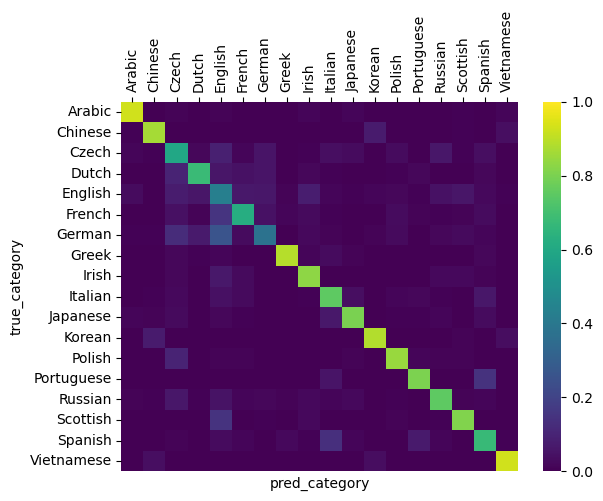

In [19]:
ax = sns.heatmap(cm_pivot_train, cmap="viridis", vmin=0.0, vmax=1.0)
ax.xaxis.tick_top()
ax.tick_params(axis='x', rotation=90)
plt.show()

In [20]:
print(predict(model, "Tchaikovsky"))

> Tchaikovsky
[(1.0, 'Russian'), (0.018, 'English'), (0.018, 'Czech')]


In [21]:
cm_test = evaluate_confusion(model, n_val_samps, train=False)

In [22]:
cm_pivot_test = (
    pd.DataFrame(cm_test, columns=all_categories)
        .assign(true_category = all_categories)
        .melt(id_vars="true_category", value_vars=all_categories)
        .rename(columns={"variable": "pred_category", "value": "prop"})
        .pivot(index="true_category", columns="pred_category", values="prop")
)

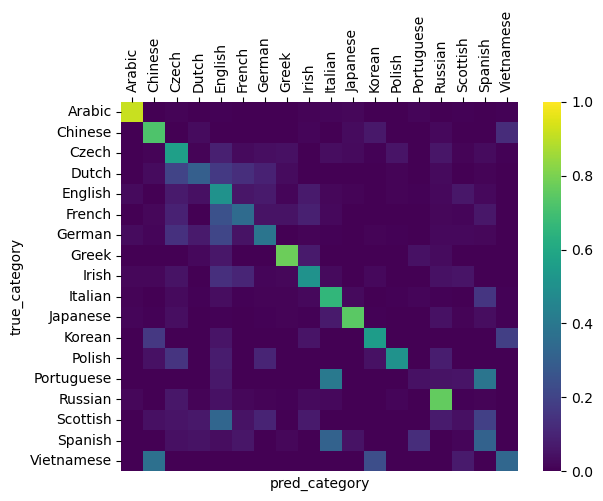

In [23]:
ax = sns.heatmap(cm_pivot_test, cmap="viridis", vmin=0.0, vmax=1.0)
ax.xaxis.tick_top()
ax.tick_params(axis='x', rotation=90)
plt.show()